# Convolutional Neural Network in PyTorch

In [1]:
import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision 
from torchvision import transforms
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import pandas as pd 

In [2]:
# HyperParams 
batch_size = 100 
num_epochs = 20
learning_rate = 0.001 
input_dim = 28 * 28 
output_dim  = 10 # digit 0 - 9 probs 
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda')
print(f'using device {device}')

using device mps


In [3]:
# Load the MNIST Data 
train = torchvision.datasets.MNIST(root='../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

# Download and load the MNIST test dataset
test= torchvision.datasets.MNIST(root='../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())


loaders = { 
    'train' : torch.utils.data.DataLoader(dataset=train, 
                                          batch_size=batch_size, 
                                          shuffle=False) , 
    'test' : torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)                                          
}                                          

In [4]:
loaders['train']

In [5]:
# Calculate the count of each digits 
count = torch.zeros((10))
for i in range(len(train)): 
    img, label = train[i]
    count[int(label)] += 1

count

tensor([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851., 5949.])

# CNN Model  with BatchNorm and Residual Connection


In [6]:
# class CNNModel(nn.Module):
#     def __init__(self):
#         super(CNNModel, self).__init__()
        
#         # Convolution 1
#         self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
#         self.bn1 = nn.BatchNorm2d(16)  # Batch normalization
#         self.relu1 = nn.ReLU()
        
#         # Max pool 1
#         self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
#         # Convolution 2
#         self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
#         self.bn2 = nn.BatchNorm2d(32)  # Batch normalization
#         self.relu2 = nn.ReLU()
        
#         # Max pool 2
#         self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
#         # Fully connected 1
#         self.fc1 = nn.Linear(32 * 4 * 4, 10) 
        
#         # Residual connection
#         self.residual = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0),
#             nn.BatchNorm2d(32)  # Batch normalization
#         )
    
#     def forward(self, x):
#         # Convolution 1
#         out = self.cnn1(x)
#         out = self.bn1(out)
#         out = self.relu1(out)

#         # Max pool 1
#         out = self.maxpool1(out)

#         # Convolution 2
#         out = self.cnn2(out)
#         out = self.bn2(out)
#         out = self.relu2(out)

#         # Max pool 2
#         out = self.maxpool2(out)

#         # Residual connection
#         residual_out = self.residual(out)
#         out = torch.add(out, residual_out)  # Use torch.add() instead of in-place addition

#         # Flatten
#         out = out.view(out.size(0), -1)

#         # Linear function (readout)
#         out = self.fc1(out)

#         return out

# CNN With BacthNorm 


In [17]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization
        self.relu2 = nn.ReLU()

        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Fully connected 1
        self.fc1 = nn.Linear(32 * 4 * 4, 10)

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.bn1(out)  # Batch normalization
        out = self.relu1(out)

        # Max pool 1
        out = self.maxpool1(out)

        # Convolution 2
        out = self.cnn2(out)
        out = self.bn2(out)  # Batch normalization
        out = self.relu2(out)

        # Max pool 2
        out = self.maxpool2(out)

        # Flatten
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)

        return out

In [18]:
# Create CNN
model = CNNModel().to(device)

# Cross Entropy Loss 
criterion = nn.CrossEntropyLoss().to(device)

# Adam Optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loaders['train']):
        
        train = images.view(100,1,28,28).to(device)
        labels = labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train).to(device)
        
        # Calculate softmax and ross entropy loss
        loss = criterion(outputs, labels).to(device)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        
        count += 1


        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in loaders['test']:
                
                test = images.view(100,1,28,28).to(device)
                
                # Forward propagation
                outputs = model(test).to(device)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1].to(device)
                
                # Total number of labels
                total += len(labels)
                
                correct += torch.sum(predicted == labels.to(device) ) 
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.07475946843624115  Accuracy: 98.2300033569336 %
Iteration: 1000  Loss: 0.04718838632106781  Accuracy: 98.48999786376953 %
Iteration: 1500  Loss: 0.04166748374700546  Accuracy: 98.66999816894531 %
Iteration: 2000  Loss: 0.027705125510692596  Accuracy: 98.68000030517578 %
Iteration: 2500  Loss: 0.017246762290596962  Accuracy: 98.83000183105469 %
Iteration: 3000  Loss: 0.1955747753381729  Accuracy: 98.88999938964844 %
Iteration: 3500  Loss: 0.013164421543478966  Accuracy: 99.1500015258789 %
Iteration: 4000  Loss: 0.0024297782219946384  Accuracy: 98.9000015258789 %
Iteration: 4500  Loss: 0.005158370826393366  Accuracy: 98.9800033569336 %
Iteration: 5000  Loss: 0.002497212029993534  Accuracy: 98.97000122070312 %
Iteration: 5500  Loss: 0.007874961942434311  Accuracy: 98.87000274658203 %
Iteration: 6000  Loss: 0.1554650217294693  Accuracy: 98.86000061035156 %
Iteration: 6500  Loss: 0.010180792771279812  Accuracy: 98.98999786376953 %
Iteration: 7000  Loss: 0.00021662269

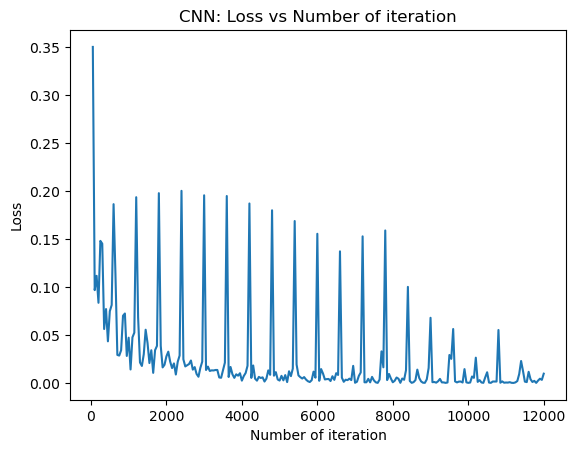

In [20]:
# visualization loss 
plt.plot(iteration_list,[ j.cpu() for j in loss_list])
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()


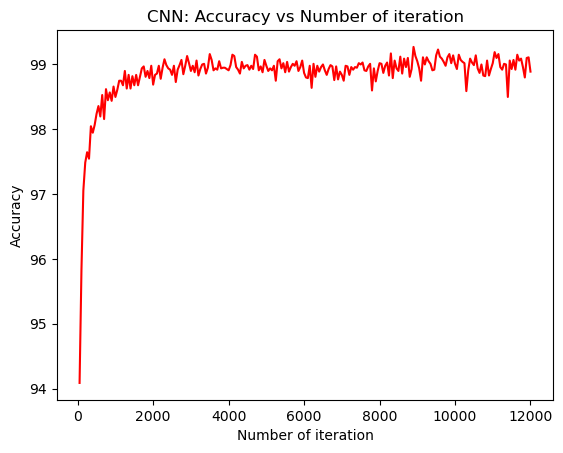

In [21]:
# visualization accuracy 
plt.plot(iteration_list,[k.cpu() for k in accuracy_list],color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()